In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
import seaborn as sns
import codecs, json
import math
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)
import random
import datetime
import shutil
print("TensorFlow version: {}".format(tf.__version__))
import random

TensorFlow version: 2.18.0


In [ ]:
# Step 1. Create a model (Feedforward Neural Network)
# Three-layer fully connected neural network with 100 nodes in each layer
n_nodes = 32
n_out = 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_out, activation=None) # linear activation
])

In [ ]:
def Heat_eqution(x, L, t, alpha): # difine the heat equation to get the exact solution
    usol = []
    for j in t:
      for i in x:
          usol.append(np.sin((np.pi*i)/L)* np.exp(-alpha*(np.pi/L)**2*j))
    return usol

In [ ]:
# Step 1: define required parameters
alpha = 0.01
L = 1

# Step 2: Construct loss function
u0 = lambda x: np.sin((np.pi*x)/L) # initial condition

def loss(model, X_PDE, X_IC, X_BC):
    # X_PDE, X_IC, X_BC are training data for PDE, IC, BC.
    #   They are numpy arrays of size N x 2:
    #     first column is location x, second column is time t
    # The input "model" is the neural network
    # Calculate loss of PDE: requires u_t (first order derivative), u_xx (second order derivative)
    # PDE: u_t - u_xx* alpha
    with tf.GradientTape(persistent=True) as g:
        g.watch(X_PDE)
        u = model(X_PDE)
        u_x = g.gradient(u, X_PDE)[:, 0:1]
    u_t = g.gradient(u, X_PDE)[:, 1:2]
    u_xx = g.gradient(u_x, X_PDE)[:, 0:1]

    loss_PDE = tf.reduce_mean((u_t - u_xx* alpha)**2)

    # Calculate loss of IC
    loss_IC = tf.reduce_mean((model(X_IC) - u0(X_IC[:, 0:1]))**2)

    # Calculate loss of BC
    u_BC = model(X_BC)
    loss_BC = tf.reduce_sum((u_BC)**2)


    # Total loss
    w1 = 1.
    w2 = 1.
    loss_total = loss_PDE + w1*loss_IC + w2*loss_BC

    return loss_total, loss_PDE, loss_IC, loss_BC

In [ ]:
# Generate training data
def BC_data(Nt):
    t = np.random.rand(Nt, 1) * 1  # t ∈ [0, 1]
    x = np.random.choice([0, 1], size=(Nt, 1))
    X = np.hstack((x, t))
    return tf.constant(X, dtype=tf.float32)


def IC_data(Nx):
    # x is random in [0, 1], t is 0
    x = np.random.rand(Nx, 1)
    t = np.zeros((Nx, 1))
    X = np.hstack((x, t))
    return tf.constant(X, dtype=tf.float32)

def PDE_data(Np):
    # x is random in [0, 1], t is random in [0, 1]
    x = np.random.rand(Np, 1)
    t = np.random.rand(Np, 1)
    X = np.hstack((x, t))
    return tf.constant(X, dtype=tf.float32)

In [ ]:
# Step 3.0. Generate training data

Nt = 100  # number of training data for BC
Nx = 200  # number of training data for IC
Np = 4000 # number of training data for PDE

X_BC = BC_data(Nt)
X_IC = IC_data(Nx)
X_PDE = PDE_data(Np)

# Create a dataset object for X_PDE
X_PDE_dataset = tf.data.Dataset.from_tensor_slices(X_PDE)
# Shuffle and batch data
X_PDE_dataset = X_PDE_dataset.shuffle(buffer_size=Np).batch(256)

In [ ]:
# Step 3.1. Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Step 3.2. Define training loop
epochs = 3000
# loop over epochs, each epoch contains all batches, each batch contains batch_size data
# read data from X_PDE_dataset
for epoch in range(epochs):
    for X_PDE_batch in X_PDE_dataset:
        with tf.GradientTape() as g:
            # calculate loss
            loss_total, loss_PDE, loss_IC, loss_BC = loss(model, X_PDE_batch, X_IC, X_BC)
        # calculate gradient
        grads = g.gradient(loss_total, model.trainable_variables)
        # update weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if (epoch+1) % 500 == 0:
        print('Epoch: %d, Loss: %f, Loss_PDE: %f, Loss_IC: %f, Loss_BC: %f' \
            % (epoch+1, loss_total, loss_PDE, loss_IC, loss_BC))

Epoch: 500, Loss: 0.001172, Loss_PDE: 0.000612, Loss_IC: 0.000353, Loss_BC: 0.000207
Epoch: 1000, Loss: 0.000161, Loss_PDE: 0.000075, Loss_IC: 0.000061, Loss_BC: 0.000025
Epoch: 1500, Loss: 0.000319, Loss_PDE: 0.000105, Loss_IC: 0.000054, Loss_BC: 0.000160
Epoch: 2000, Loss: 0.000127, Loss_PDE: 0.000075, Loss_IC: 0.000044, Loss_BC: 0.000009
Epoch: 2500, Loss: 0.000842, Loss_PDE: 0.000087, Loss_IC: 0.000056, Loss_BC: 0.000699
Epoch: 3000, Loss: 0.000276, Loss_PDE: 0.000079, Loss_IC: 0.000041, Loss_BC: 0.000156


In [ ]:
def plot_2D(xlim=None, ylim=None, xticks=None, yticks=None,
            xlabel = 'x', ylabel = 'y',
            figsize=(7.3, 5.9), label_size=18, tick_size=16, spine_width=1.5):

    fig, ax = plt.subplots(figsize=figsize)

    #-----Format Axis ---------------------------
    # labels and size
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)

    # limits, ticks and size
    if xlim != None:
        ax.set_xlim(*xlim)
    if ylim != None:
        ax.set_ylim(*ylim)

    if xticks != None:
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)

    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)

    #---------- Spines -------
    ax.spines["top"].set_linewidth(spine_width)
    ax.spines["left"].set_linewidth(spine_width)
    ax.spines["right"].set_linewidth(spine_width)
    ax.spines["bottom"].set_linewidth(spine_width)

    return fig, ax

In [ ]:
# Find the exact solution
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
dt = 0.00001
dx = x[1] - x[0]

# Generate usol as a 2D numpy array (time points, spatial points)
usol = np.zeros((len(t), len(x)))
for i in range(len(t)):
    for j in range(len(x)):
        usol[i, j] = np.sin((np.pi*x[j])/L)* np.exp(-alpha*(np.pi/L)**2*t[i])

In [ ]:
def solutionplot(u_pred, times):
    '''
    Slices of the solution at points t = 0, t = 0.5, and t = 1.0
    '''

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, len(times))
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    for i, t_val in enumerate(times):
        ax = plt.subplot(gs1[0, i])

        # Find the index in usol corresponding to the current time value
        # Assuming t is evenly spaced in usol
        # Use np.abs(t - t_val).argmin() to find the closest index in t
        t_index = np.abs(t - t_val).argmin()


        ax.plot(x.squeeze(),usol[t_index,:], 'b--', linewidth = 2, label = 'Exact')
        ax.plot(x.squeeze(),u_pred[i,:], 'r--',  markevery=5, markersize=3, markeredgewidth=1.5, label = 'Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')
        ax.set_title(f'$t = {t_val}$', fontsize = 10)
        ax.axis('square')
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([0.0,1.1])
        if i == 1: # Add legend to the middle plot
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=False)

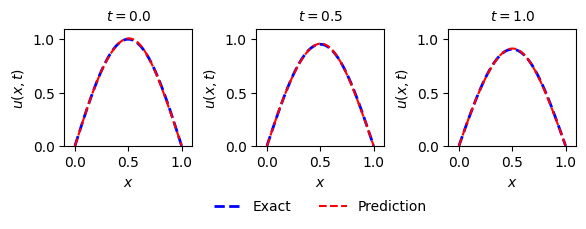

In [ ]:
# Visualization
X = tf.linspace(0.0, 1., 100)
X = tf.reshape(X, (-1, 1))

# Define the time points for visualization
times_to_plot = [0.0, 0.5, 1.0]

# Generate predictions for each time point
u_preds = []
for tt in times_to_plot:
    X_inp = tf.constant(np.hstack((X.numpy(), tt * np.ones_like(X.numpy()))), dtype=tf.float32)
    u_pred = model(X_inp)
    u_preds.append(u_pred.numpy())

# Stack the predictions for different time points and reshape to (num_times, num_spatial_points)
u_preds = np.vstack(u_preds).reshape(len(times_to_plot), -1)

# Plot the solutions
solutionplot(u_preds, times_to_plot)